In [35]:
# from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
import torch
from tqdm.auto import tqdm
import pickle
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud
from point_e.util.pc_to_mesh import marching_cubes_mesh
import time

In [2]:
t1 = time.time()

In [3]:
def load_model(modelfile):
	loaded_model = pickle.load(open(modelfile, 'rb'))
	return loaded_model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
pipe = load_model('models\pipe.pkl')
sampler = load_model('models\sampler.pkl')

In [6]:
t2 = time.time()

In [7]:
prompt = "doge inspired beanbag"

In [8]:
pipe.to(device)
pipe.enable_attention_slicing()

In [9]:
image = pipe(prompt).images[0]
image.save("prompt"+".png")
pipe.to('cpu')
import gc
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/50 [00:00<?, ?it/s]

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

82

In [10]:
t3 = time.time()

In [11]:
imgpath = 'prompt.png'
img = Image.open(imgpath)
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

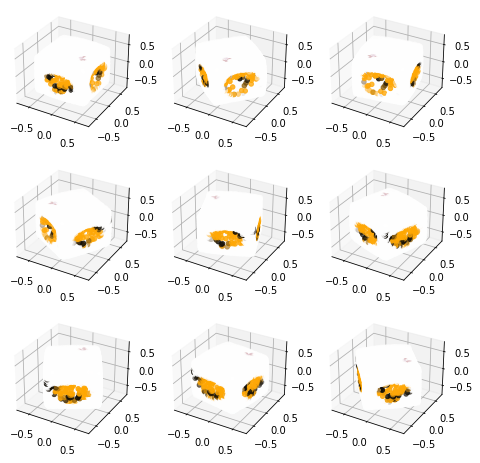

In [12]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3)

In [13]:
type(fig)

matplotlib.figure.Figure

In [14]:
fig.savefig('fig.jpg')

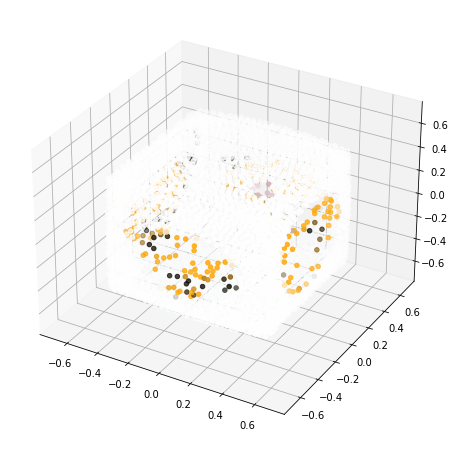

In [15]:
fig_full = plot_point_cloud(pc)

In [16]:
t4 = time.time()

In [17]:
times = {'Part1' : t2-t1, 
         'Part2' : t3-t2,
         'Part3' : t4-t3,
         'Total' : t4-t1}

In [18]:
times

{'Part1': 20.590872049331665,
 'Part2': 40.29724097251892,
 'Part3': 142.1911814212799,
 'Total': 203.0792944431305}

In [19]:
import gc
torch.cuda.empty_cache()
gc.collect()

953

In [20]:
type(pc)

point_e.util.point_cloud.PointCloud

In [28]:
pc.save('img.npz')

In [31]:
pc_test = PointCloud.load('img.npz')

In [32]:
pc_test

PointCloud(coords=array([[-0.16953763, -0.20872062, -0.5       ],
       [-0.02793819,  0.50105476, -0.30904797],
       [ 0.2590727 , -0.48448756, -0.47593403],
       ...,
       [ 0.42361206, -0.13930026, -0.5006236 ],
       [ 0.48863837,  0.2762418 , -0.46551475],
       [ 0.47662103,  0.4952051 ,  0.07025144]], dtype=float32), channels={'R': array([0.9960785 , 0.70980394, 0.9960785 , ..., 0.9960785 , 1.        ,
       1.        ], dtype=float32), 'G': array([0.9960785 , 0.54901963, 0.9960785 , ..., 1.        , 1.        ,
       1.        ], dtype=float32), 'B': array([1.        , 0.27058825, 0.9960785 , ..., 1.        , 1.        ,
       1.        ], dtype=float32)})

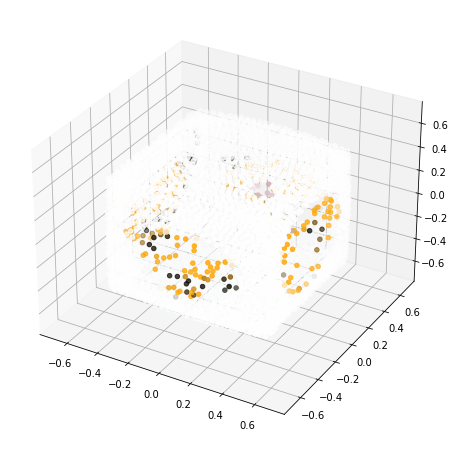

In [34]:
fig = plot_point_cloud(pc_test)

In [36]:
mesh_model = load_model('models\mesh_model.pkl')

In [37]:
mesh = marching_cubes_mesh(
    pc=pc_test,
    model=mesh_model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)

In [4]:
from zipfile import ZipFile

In [5]:
with ZipFile('check.zip', 'w') as zip_object:
    zip_object.write('fig.jpg')
    zip_object.write('fig.png')